# Timeseries classification using Conv1D, LSTM

**Author:** [hfawaz](https://github.com/hfawaz/), [Vijay Yalamanchili](https://github.com/vijaykrishnay/)<br>
**Date created:** 2020/07/21<br>
**Last modified:** 2020/12/15<br>
**Description:** Training a timeseries classifier from scratch on the FordA dataset from the UCR/UEA archive.

## Introduction

This example shows how to do timeseries classification using a combination of Conv1D, LSTM layers starting from raw
CSV timeseries files on disk. We demonstrate the workflow on the FordA dataset from the
[UCR/UEA archive](https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/).

## Setup

In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

## Load the data: the FordA dataset

### Dataset description

The dataset we are using here is called FordA.
The data comes from the UCR archive.
The dataset contains 3601 training instances and another 1320 testing instances.
Each timeseries corresponds to a measurement of engine noise captured by a motor sensor.
For this task, the goal is to automatically detect the presence of a specific issue with
the engine. The problem is a balanced binary classification task. The full description of
this dataset can be found [here](http://www.j-wichard.de/publications/FordPaper.pdf).

### Read the TSV data

We will use the `FordA_TRAIN` file for training and the
`FordA_TEST` file for testing. The simplicity of this dataset
allows us to demonstrate effectively how to use ConvNets for timeseries classification.
In this file, the first column corresponds to the label.

In [2]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

In [3]:
x_train

array([[-0.79717168, -0.66439208, -0.37301463, ..., -0.66439208,
        -1.0737958 , -1.5643427 ],
       [ 0.80485472,  0.63462859,  0.37347448, ..., -0.71488505,
        -0.56044294, -0.31908642],
       [ 0.7279851 ,  0.11128392, -0.49912439, ...,  0.39446303,
         0.33940042,  0.25539062],
       ...,
       [-0.57005428, -0.33316523, -0.29351853, ..., -1.3937145 ,
        -0.94273327, -0.27072168],
       [ 2.0067321 ,  2.0791499 ,  2.0220362 , ..., -0.43214504,
        -0.44123126, -0.28070891],
       [-0.12524091, -0.32536268, -0.48823697, ...,  0.55576053,
         0.57445102,  0.57311598]])

## Visualize the data

Here we visualize one timeseries example for each class in the dataset.

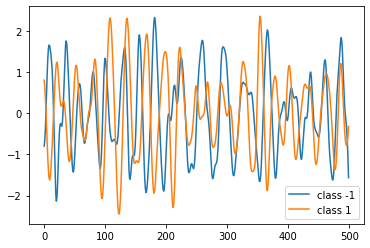

In [4]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

## Standardize the data

Our timeseries are already in a single length (176). However, their values are
usually in various ranges. This is not ideal for a neural network;
in general we should seek to make the input values normalized.
For this specific dataset, the data is already z-normalized: each timeseries sample
has a mean equal to zero and a standard deviation equal to one. This type of
normalization is very common for timeseries classification problems, see
[Bagnall et al. (2016)](https://link.springer.com/article/10.1007/s10618-016-0483-9).

Note that the timeseries data used here are univariate, meaning we only have one channel
per timeseries example.
We will therefore transform the timeseries into a multivariate one with one channel
using a simple reshaping via numpy.
This will allow us to construct a model that is easily applicable to multivariate time
series.

In [5]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

Finally, in order to use `sparse_categorical_crossentropy`, we will have to count
the number of classes beforehand.

In [6]:
num_classes = len(np.unique(y_train))

Now we shuffle the training set because we will be using the `validation_split` option
later when training.

In [7]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

Standardize the labels to positive integers.
The expected labels will then be 0 and 1.

In [8]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

## Build a model

We build a model using LSTM as the first later followed by a fully connected layer. Dropout layer is used for regularization.

The following hyperparameters (# of LSTM, dense units, dropout rate, learning rate, batch size, the usage of BatchNorm) were tuned to arrive at the below values. 

In [9]:
def make_model(input_shape):
    dropout_rate=0.1
    
    input_layer = keras.layers.Input(input_shape)

    conv1a = keras.layers.Conv1D(filters=8, kernel_size=3, padding="same")(input_layer)
    conv1a = keras.layers.BatchNormalization()(conv1a)
    conv1a = keras.layers.ReLU()(conv1a)
    conv1a = keras.layers.Dropout(dropout_rate)(conv1a)
    
    conv1b = keras.layers.Conv1D(filters=8, kernel_size=5, padding="same")(input_layer)
    conv1b = keras.layers.BatchNormalization()(conv1b)
    conv1b = keras.layers.ReLU()(conv1b)
    conv1b = keras.layers.Dropout(dropout_rate)(conv1b)

    conv1 = keras.layers.Concatenate(axis=-1)([conv1a, conv1b])
    
    conv2 = keras.layers.Conv1D(filters=24, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    conv2 = keras.layers.Dropout(dropout_rate)(conv2)
    
#     conv3a_reduce = keras.layers.MaxPooling1D(pool_size=5, strides=5, padding="valid")(conv2)
    conv3a_reduce = keras.layers.Conv1D(
        filters=8, kernel_size=10, padding="valid", strides=10
    )(conv2)
    conv3a_reduce = keras.layers.BatchNormalization()(conv3a_reduce)
    conv3a_reduce = keras.layers.ReLU()(conv3a_reduce)
    conv3a_reduce = keras.layers.Dropout(dropout_rate)(conv3a_reduce)

    conv3a_flat = keras.layers.Flatten()(conv3a_reduce)
    dense_conv = keras.layers.Dense(4, activation="relu")(conv3a_flat)
    
    lstm1 = keras.layers.LSTM(24, return_sequences=False)(conv1)
    lstm1 = keras.layers.BatchNormalization()(lstm1)
    lstm1 = keras.layers.Dropout(dropout_rate)(lstm1)
    
    dense_lstm = keras.layers.Dense(4, activation="relu")(lstm1)
    
    dense_combined = keras.layers.Concatenate()([dense_conv, dense_lstm])
    
    output_layer = keras.layers.Dense(num_classes, activation="softmax")(dense_combined)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 500, 8)       32          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 500, 8)       48          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 500, 8)       32          conv1d[0][0]                     
______________________________________________________________________________________________

## Train the model

In [10]:
epochs = 100
batch_size = 32
learning_rate = 0.001
model_name = "best_model_conv_lstm.h5"
rho = 0.9
# 
callbacks = [
    keras.callbacks.ModelCheckpoint(
        model_name, save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=15, min_lr=0.00005
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, verbose=1),
]
model.compile(
    # RMSProp worked better than Adam solver for this problem, model setup.
    optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate, rho=rho),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/100
90/90 [==============================] - 9s 80ms/step - loss: 0.7176 - sparse_categorical_accuracy: 0.4942 - val_loss: 0.6907 - val_sparse_categorical_accuracy: 0.5118
Epoch 2/100
90/90 [==============================] - 6s 71ms/step - loss: 0.6626 - sparse_categorical_accuracy: 0.5554 - val_loss: 0.7088 - val_sparse_categorical_accuracy: 0.5035
Epoch 3/100
90/90 [==============================] - 6s 72ms/step - loss: 0.5986 - sparse_categorical_accuracy: 0.6372 - val_loss: 0.7358 - val_sparse_categorical_accuracy: 0.5118
Epoch 4/100
90/90 [==============================] - 7s 72ms/step - loss: 0.5534 - sparse_categorical_accuracy: 0.6841 - val_loss: 0.7579 - val_sparse_categorical_accuracy: 0.5312
Epoch 5/100
90/90 [==============================] - 7s 73ms/step - loss: 0.5020 - sparse_categorical_accuracy: 0.7383 - val_loss: 0.9086 - val_sparse_categorical_accuracy: 0.5562
Epoch 6/100
90/90 [==============================] - 7s 74ms/step - loss: 0.4422 - sparse_categorica

90/90 [==============================] - 7s 76ms/step - loss: 0.1451 - sparse_categorical_accuracy: 0.9381 - val_loss: 0.2886 - val_sparse_categorical_accuracy: 0.8890
Epoch 47/100
90/90 [==============================] - 7s 75ms/step - loss: 0.1416 - sparse_categorical_accuracy: 0.9442 - val_loss: 0.2523 - val_sparse_categorical_accuracy: 0.8974
Epoch 48/100
90/90 [==============================] - 7s 75ms/step - loss: 0.1527 - sparse_categorical_accuracy: 0.9465 - val_loss: 0.3366 - val_sparse_categorical_accuracy: 0.8877
Epoch 49/100
90/90 [==============================] - 7s 75ms/step - loss: 0.1347 - sparse_categorical_accuracy: 0.9480 - val_loss: 0.2587 - val_sparse_categorical_accuracy: 0.9071
Epoch 50/100
90/90 [==============================] - 7s 75ms/step - loss: 0.1426 - sparse_categorical_accuracy: 0.9468 - val_loss: 0.2255 - val_sparse_categorical_accuracy: 0.9126
Epoch 51/100
90/90 [==============================] - 7s 75ms/step - loss: 0.1257 - sparse_categorical_accur

90/90 [==============================] - 7s 77ms/step - loss: 0.0995 - sparse_categorical_accuracy: 0.9616 - val_loss: 0.2515 - val_sparse_categorical_accuracy: 0.9140
Epoch 92/100
90/90 [==============================] - 7s 77ms/step - loss: 0.1008 - sparse_categorical_accuracy: 0.9574 - val_loss: 0.2541 - val_sparse_categorical_accuracy: 0.9071
Epoch 93/100
90/90 [==============================] - 7s 75ms/step - loss: 0.0973 - sparse_categorical_accuracy: 0.9607 - val_loss: 0.2500 - val_sparse_categorical_accuracy: 0.9126
Epoch 94/100
90/90 [==============================] - 7s 76ms/step - loss: 0.0992 - sparse_categorical_accuracy: 0.9623 - val_loss: 0.2509 - val_sparse_categorical_accuracy: 0.9085
Epoch 95/100
90/90 [==============================] - 7s 76ms/step - loss: 0.0975 - sparse_categorical_accuracy: 0.9673 - val_loss: 0.2482 - val_sparse_categorical_accuracy: 0.9154
Epoch 96/100
90/90 [==============================] - 7s 76ms/step - loss: 0.0911 - sparse_categorical_accur

## Evaluate model on test data

In [11]:
model = keras.models.load_model(model_name)

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 1s 17ms/step - loss: 0.2655 - sparse_categorical_accuracy: 0.9030
Test accuracy 0.903030276298523
Test loss 0.26552173495292664


## Plot the model's training and validation loss

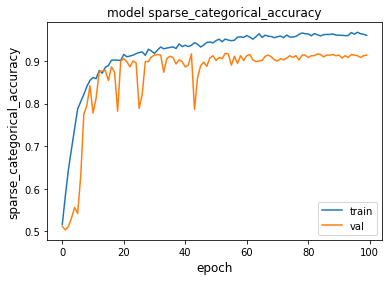

In [12]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

Training accuracy stabilizes around 200 epochs. Both Validation and test accuracy are very close to training accuracy indicating that the model generalizes well.